Import all required libraries

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
%matplotlib inline

Step 1: Obtain Camera Calibration Parameters

In [2]:
debug = True
calibration_images_path = 'calibration_wide/GO*.jpg'
calibration_test_image_path = 'calibration_wide/GOPR0032.jpg'
road_with_lanes_path = 'test_images/test1.jpg'
path = "signs_vehicles_xygrad.png"

In [3]:
def convert_BGR_to_RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def convert_BGR_to_GRAY(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
def import_calibration_images(path):
    images = glob.glob(path)
    return images

In [5]:
def obtain_calibration_parameters(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*8,3), np.float32)
    objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list of calibration images and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    if debug == True:
        print("The number of images passed in is: " + str(len(images)))
        print("The number of objpoints obtained is: " + str(len(objpoints)))
        print("The number of imgpoints obtained is: " + str(len(imgpoints)))
        
    return objpoints, imgpoints

In [6]:
def calibrate_img(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)   
    return mtx, dist

In [7]:
def undistort_img(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [8]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = undistort_img(img, mtx, dist)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped

The number of images passed in is: 36
The number of objpoints obtained is: 35
The number of imgpoints obtained is: 35


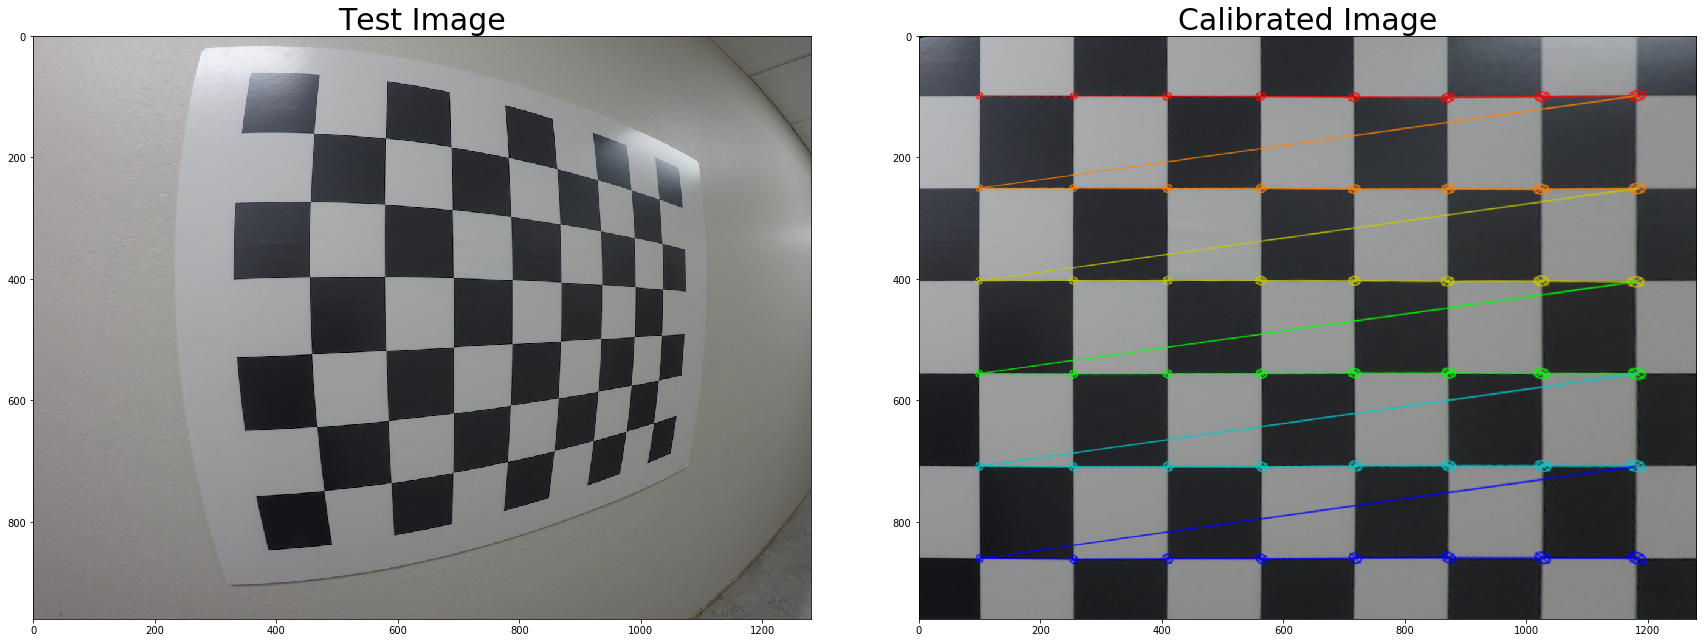

In [9]:
calibration_parameters = obtain_calibration_parameters(import_calibration_images(calibration_images_path))
test_image = cv2.imread(calibration_test_image_path)

mtx, dist = calibrate_img(test_image, calibration_parameters[0], calibration_parameters[1])
warped = corners_unwarp(test_image, 8, 6, mtx, dist)

if debug == True:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.set_title('Test Image', fontsize=30)
    ax1.imshow(convert_BGR_to_RGB(test_image))
    ax2.set_title('Calibrated Image', fontsize=30)
    ax2.imshow(convert_BGR_to_RGB(warped))
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

2. Undistorting a test image

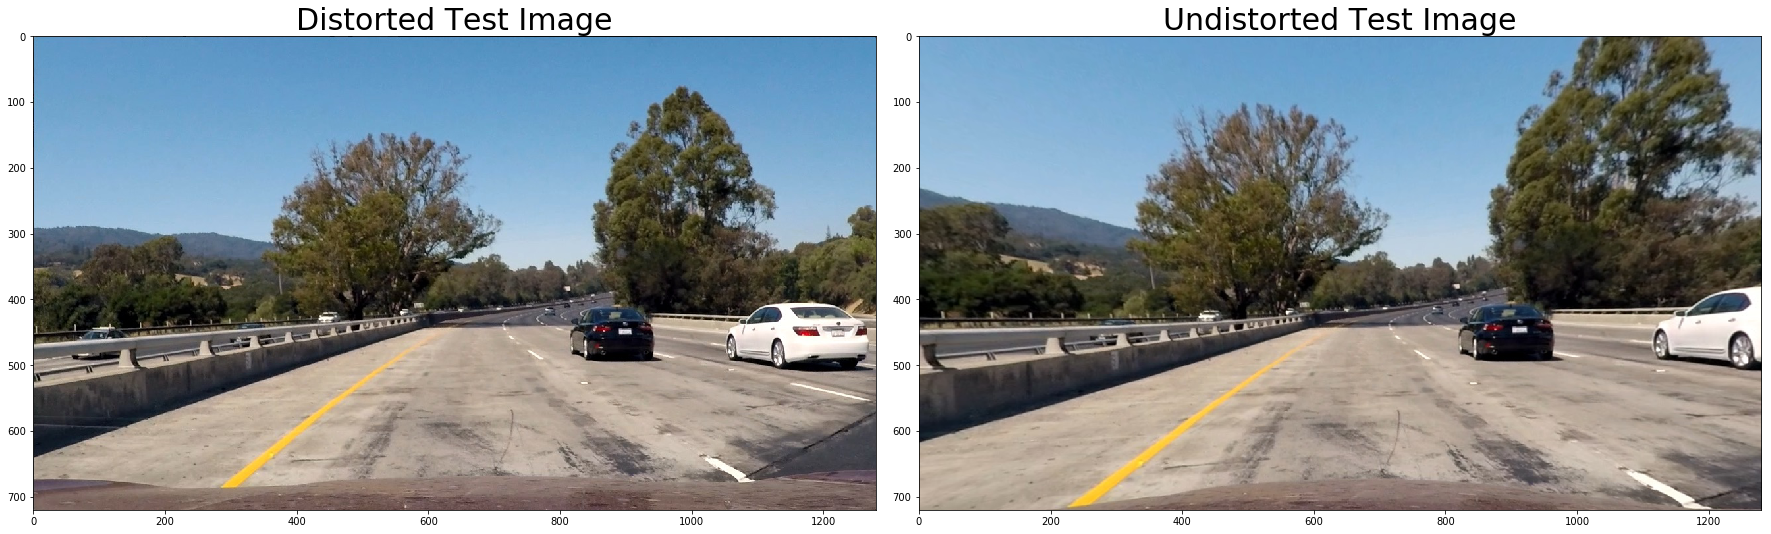

In [10]:
road_image = cv2.imread(road_with_lanes_path)
road_image_calibration_parameters = calibrate_img(road_image, calibration_parameters[0], calibration_parameters[1])
undistorted_road = undistort_img(road_image, road_image_calibration_parameters[0], road_image_calibration_parameters[1])

if debug == True:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.set_title('Distorted Test Image', fontsize=30)
    ax1.imshow(convert_BGR_to_RGB(road_image))
    ax2.set_title('Undistorted Test Image', fontsize=30)
    ax2.imshow(convert_BGR_to_RGB(undistorted_road))
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Perspective Transform

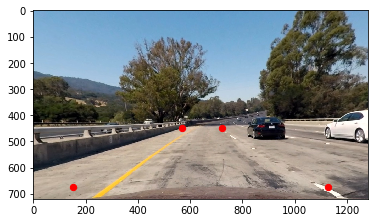

In [28]:
plt.imshow(convert_BGR_to_RGB(undistorted_road))
plt.scatter(570, 450, s = 40, c = 'r') #top right
plt.scatter(710, 450, s = 40, c = 'r') #bottom right
plt.scatter(1126, 673, s = 40, c = 'r') #top left
plt.scatter(153, 673, s = 40, c = 'r') #bottom left

In [38]:
def find_edges(image, ksize = 11, mask_half=False):
    
#     blur = cv2.GaussianBlur(image, (ksize, ksize), 0)
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
#     gray = cv2.cvtColor(blur.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = (0.5*image[:,:,0] + 0.4*image[:,:,1] + 0.1*image[:,:,2]).astype(np.uint8)
    s = hls[:,:,2]
    
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_three)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary

    combined_binary = np.clip(cv2.bitwise_and(gray_binary, 
                        cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')

    # Mask out top half of image to reduce distractions
    # Only used when unwarped image is passed in
    if mask_half:
        print(ceil(image.shape[0]//2))
        combined_binary[:ceil(image.shape[0]//2)] = 0
#     else:
#         plt.subplot(2, 3, 1)
#         plt.imshow(s_binary, cmap='gray')
#         plt.subplot(2, 3, 2)
#         plt.imshow(mask_three, cmap='gray')
#         plt.subplot(2, 3, 3)
#         plt.imshow((laplacian), cmap='gray')
#         plt.subplot(2, 3, 4)
#         plt.imshow(gray_binary, cmap='gray')
#         plt.subplot(2, 3, 5)
#         plt.imshow(cv2.equalizeHist(s), cmap='gray')
#         plt.subplot(2, 3, 6)
#         plt.imshow(combined_binary, cmap='gray')

    return combined_binary

In [49]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    offset = 200
    #coordinates of the four corners in the ORIGINAL IMAGE
    src = np.float32(
        [[30, 670],
         [1250, 670],
         [710, 448],
         [570, 448]])
    
    dst = np.float32(
        [[0, img.shape[1]],
         [img.shape[0], img.shape[1]],
         [img.shape[0], 0],
         [0, 0]])
    
    #Get the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Create warped image using linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

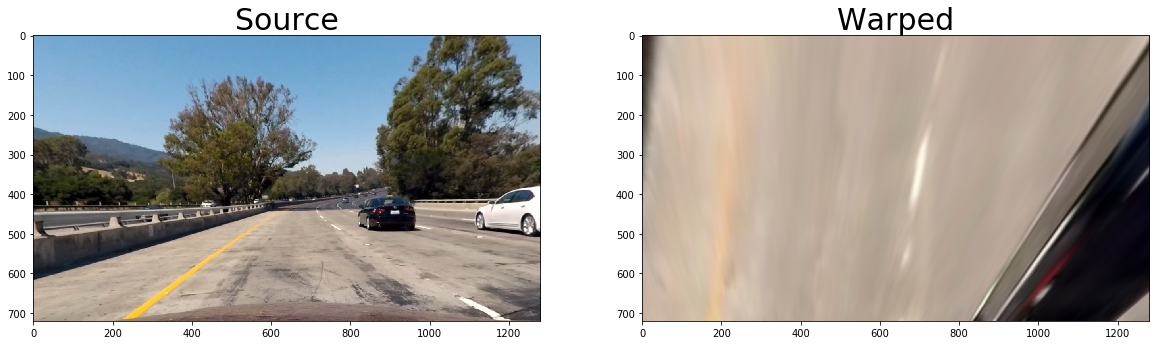

In [50]:
warped_im = warp(undistorted_road)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Source', fontsize=30)
ax1.imshow(convert_BGR_to_RGB(undistorted_road))
ax2.set_title('Warped', fontsize=30)
ax2.imshow(convert_BGR_to_RGB(warped_im))

Applying Sobel

In [14]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

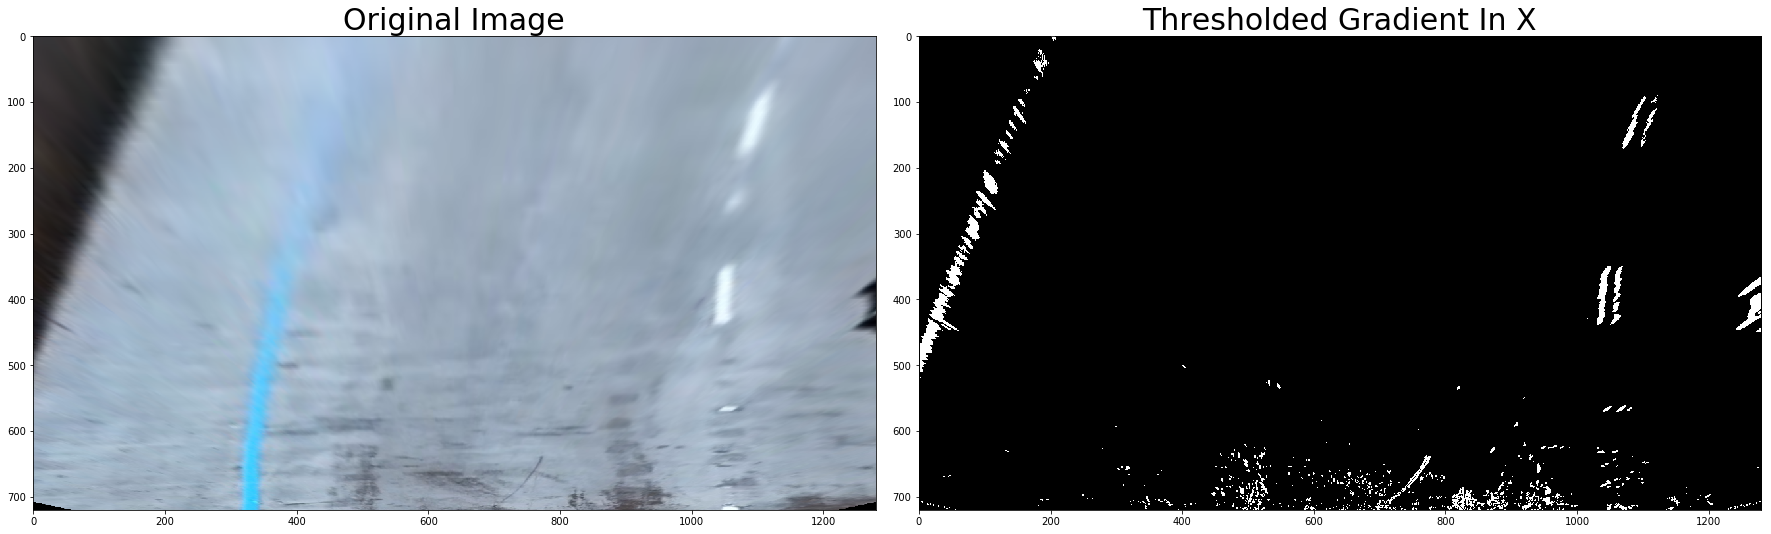

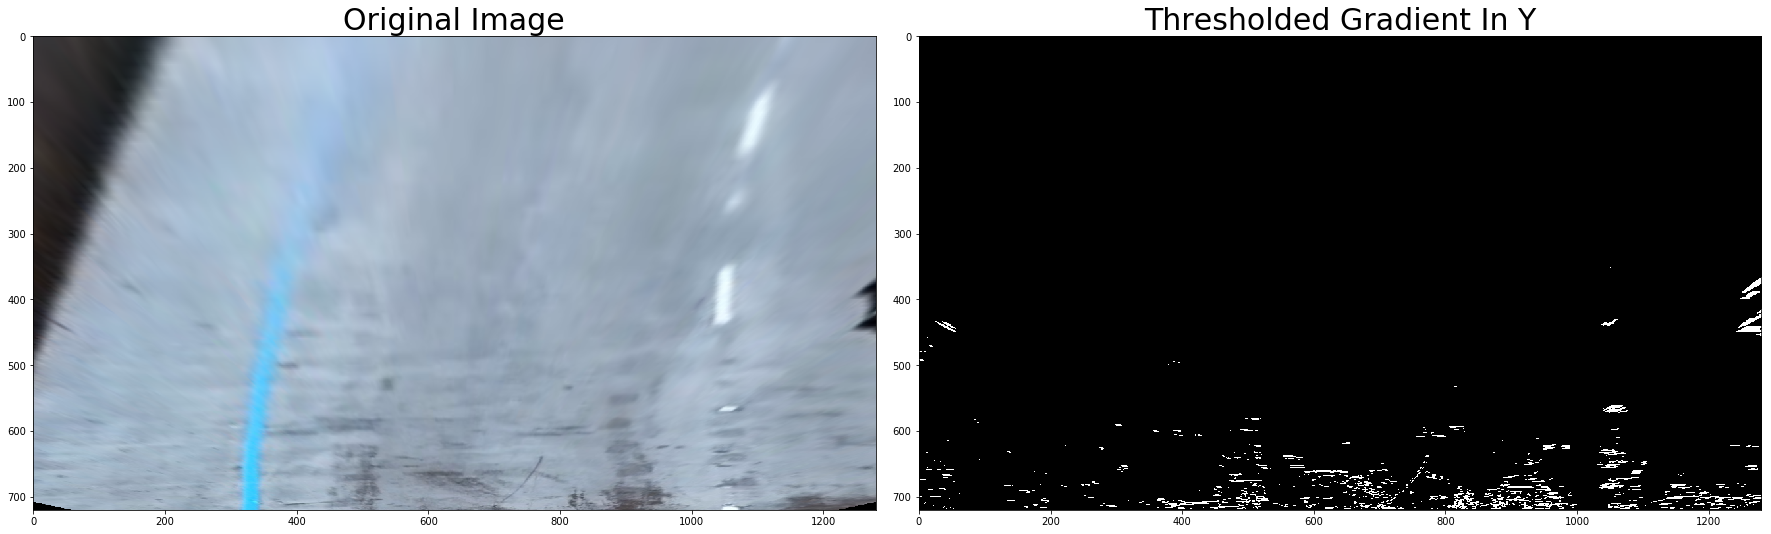

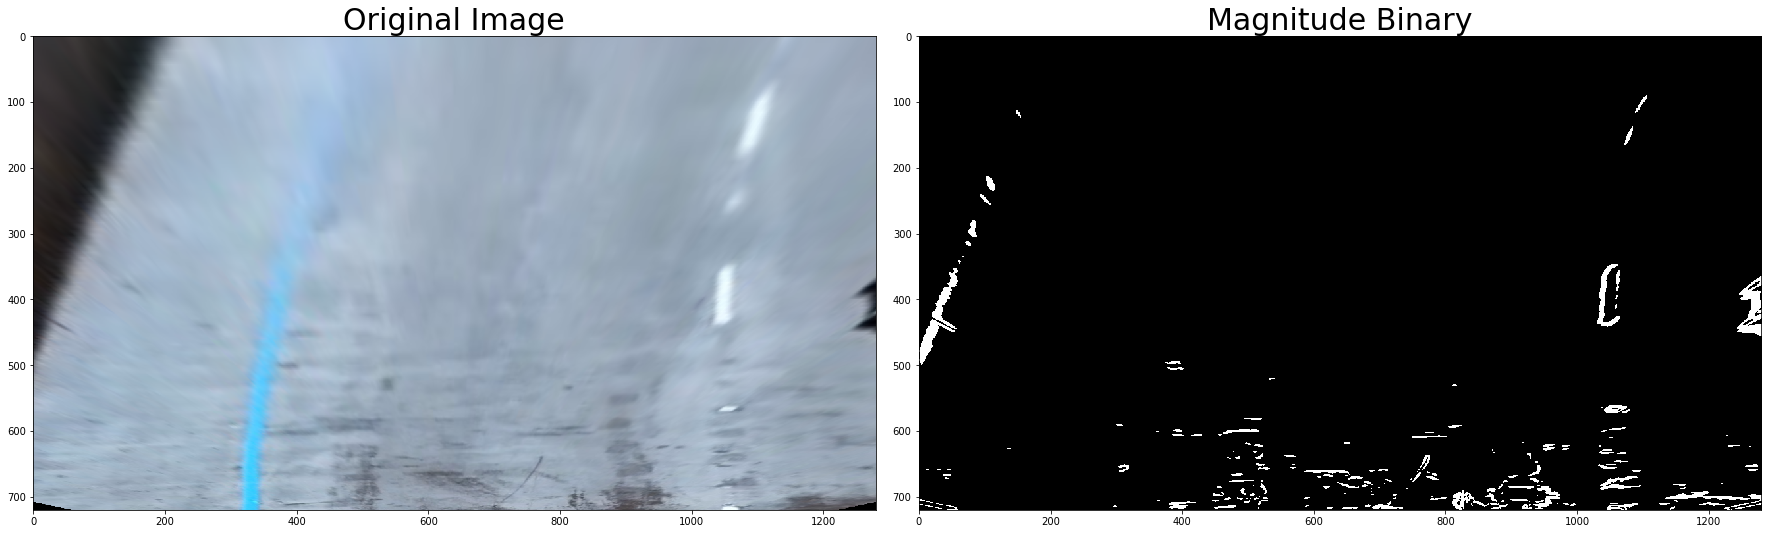

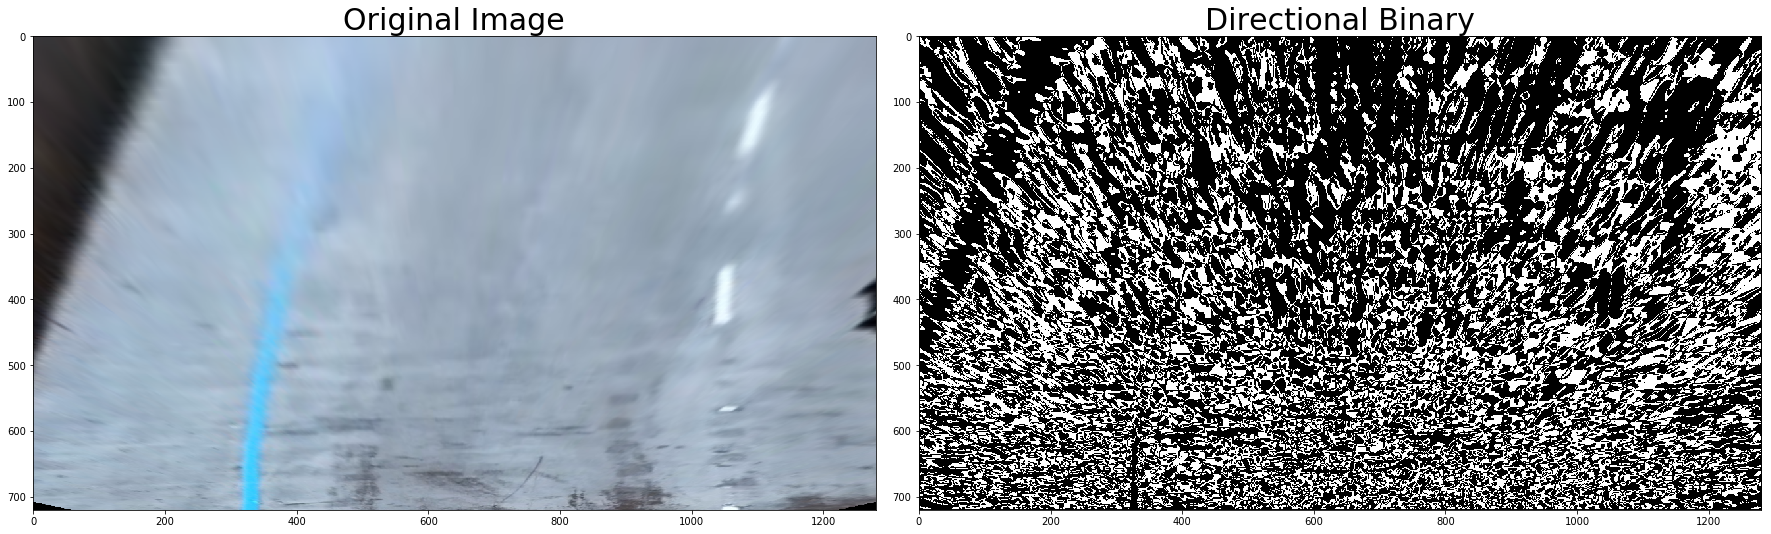

In [33]:
image = warped_im

ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded Gradient In X', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax3.imshow(image)
ax3.set_title('Original Image', fontsize=30)
ax4.imshow(grady, cmap='gray')
ax4.set_title('Thresholded Gradient In Y', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax5, ax6) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax5.imshow(image)
ax5.set_title('Original Image', fontsize=30)
ax6.imshow(mag_binary, cmap='gray')
ax6.set_title('Magnitude Binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax7, ax8) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax7.imshow(image)
ax7.set_title('Original Image', fontsize=30)
ax8.imshow(dir_binary, cmap='gray')
ax8.set_title('Directional Binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

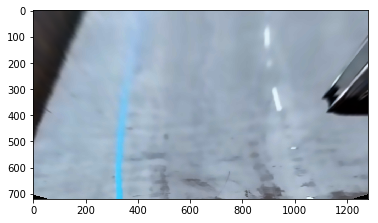

In [16]:
denoised_image = cv2.fastNlMeansDenoisingColored(warped_im, None, 10, 10, 7, 21)

plt.imshow(denoised_image)

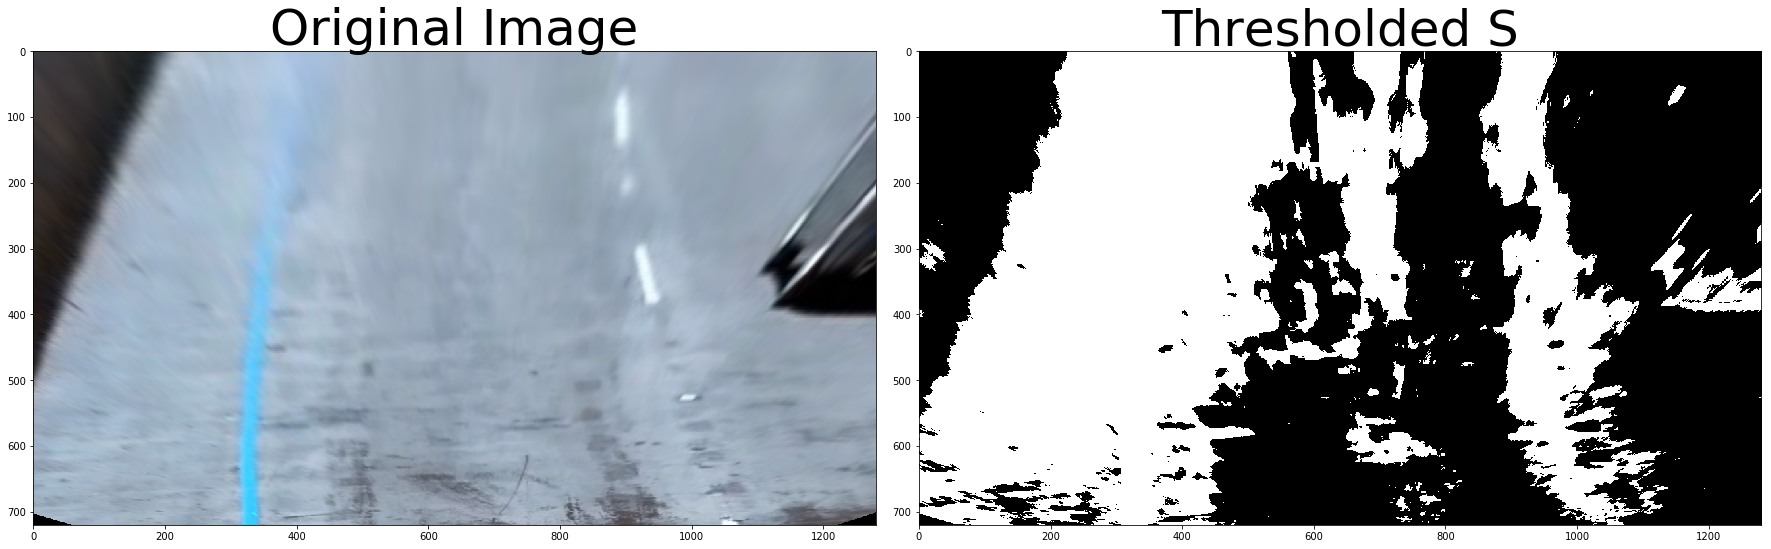

In [17]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

binary_warped = hls_select(warped_im, thresh=(50, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

/Users/holovisinternational/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


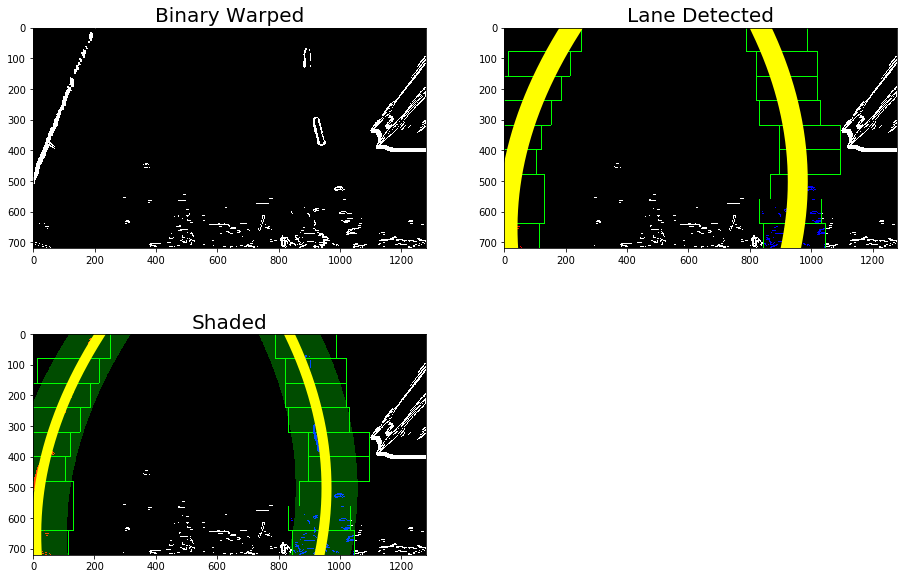

In [18]:
# Take a histogram of the bottom half of the image
histogram = np.sum(mag_binary[mag_binary.shape[0]/2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((mag_binary, mag_binary, mag_binary))*255
window_img = np.zeros_like(out_img)

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(mag_binary.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = mag_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

plt.figure(figsize=(4, 6))
plt.subplot(2,2,1)
plt.imshow(mag_binary, cmap='gray')
plt.title('Binary Warped', fontsize = 20)

plt.subplot(2,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow', linewidth = 20)
plt.plot(right_fitx, ploty, color='yellow', linewidth = 20)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected', fontsize = 20)

plt.subplot(2,2,3)
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow', linewidth = 10)
plt.plot(right_fitx, ploty, color='yellow', linewidth = 10)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Shaded', fontsize = 20)

plt.subplots_adjust(left=0., right=3., top=1.3, bottom=0.)


In [ ]:
ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: " + str(curvature))

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video_path = 'yellow.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(convert_BGR_to_GRAY) #put pipeline here
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import glob
# import cv2
# %matplotlib inline

# binary_warped = mpimg.imread('warped-example.jpg')


In [ ]:
# # Take a histogram of the bottom half of the image
# histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

# # Create an output image to draw on and  visualize the result
# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# window_img = np.zeros_like(out_img)

# # Finding peak of the left and right halves of the histogram
# # These will be the starting point for the left and right lines
# midpoint = np.int(histogram.shape[0]/2)
# leftx_base = np.argmax(histogram[:midpoint])
# rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# # Number of sliding windows
# nwindows = 9

# # Height of windows
# window_height = np.int(binary_warped.shape[0]/nwindows)

# # Identifing the x and y positions of all nonzero pixels in the image
# nonzero = binary_warped.nonzero()
# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])


# # Current positions to be updated for each window
# leftx_current = leftx_base
# rightx_current = rightx_base

# # Margin in which to search
# margin = 100

# # Minimum number of pixels found to recenter window
# minpix = 50

# # Empty lists to receive left and right lane pixel indices
# left_lane_inds = []
# right_lane_inds = []

# # Steping through windows one by one
# for window in range(nwindows):
#     # Identify window boundaries in x and y (and right and left)
#     win_y_low = binary_warped.shape[0] - (window+1)*window_height
#     win_y_high = binary_warped.shape[0] - window*window_height
#     win_xleft_low = leftx_current - margin
#     win_xleft_high = leftx_current + margin
#     win_xright_low = rightx_current - margin
#     win_xright_high = rightx_current + margin
    
#     # Drawing the windows on the visualization image
#     cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#     cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
#     # Identifing the nonzero pixels in x and y within the window
#     good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
#     good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
#     # Appending these indices to the lists
#     left_lane_inds.append(good_left_inds)
#     right_lane_inds.append(good_right_inds)
    
#     # Recenter next window on their mean position
#     if len(good_left_inds) > minpix:
#         leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#     if len(good_right_inds) > minpix:        
#         rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# # Concatenating the arrays of indices
# left_lane_inds = np.concatenate(left_lane_inds)
# right_lane_inds = np.concatenate(right_lane_inds)

# # Extracting left and right line pixel positions
# leftx = nonzerox[left_lane_inds]
# lefty = nonzeroy[left_lane_inds] 
# rightx = nonzerox[right_lane_inds]
# righty = nonzeroy[right_lane_inds] 

# # Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)

# ## Visualization
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
# left_line_pts = np.hstack((left_line_window1, left_line_window2))
# right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
# right_line_pts = np.hstack((right_line_window1, right_line_window2))

# plt.figure(figsize=(4, 6))
# plt.subplot(2,2,1)
# plt.imshow(binary_warped, cmap='gray')
# plt.title('Binary Warped', fontsize = 20)

# plt.subplot(2,2,2)
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow', linewidth = 20)
# plt.plot(right_fitx, ploty, color='yellow', linewidth = 20)
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.title('Lane Detected', fontsize = 20)

# plt.subplot(2,2,3)
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.title('Shaded', fontsize = 20)

# plt.subplots_adjust(left=0., right=3., top=1.3, bottom=0.)


In [ ]:
# ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
# xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
# y_eval = 700
# midx = 650

# y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
# y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

# curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
# print("Radius of Curvature: %f" % curvature)